# CNN Reverse Layers


In [1]:
#importing libraries
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



## MODEL BUILDING

In [3]:
model = Sequential() #initializing the model

In [ ]:
#ADDING THE LAYERS 
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 1), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu',  kernel_regularizer=l2(0.001)))
model.add(Dense(4, activation='softmax'))

In [6]:
#compiling the model
model.compile(optimizer= "adam", loss = 'categorical_crossentropy',
              metrics = ["accuracy", 
                         Precision(name='precision'), 
                         Recall(name='recall'), 
                         AUC(name='auc')])

In [7]:
#display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,632,612 (21.49 MB)

 Trainable params: 5,632,612 (21.49 MB)

 Non-trainable params: 0 (0.00 B)

# SPLITTING IN TRAIN AND TEST SET

In [9]:
#TRAIN and TEST SPLIT 
# Load the dataset witouth the 'other' class
base_dir = 'PATH TO YOUR LABELLED IMAGES'
labels = ['Advertisements', 'E-mail', 'Handwritten Documents', 'Resumè']
file_paths = []
file_labels = []

# Create a list of file paths and labels
for label in labels:
    folder_path = os.path.join(base_dir, label)
    files = os.listdir(folder_path)
    for file in files:
        file_paths.append(os.path.join(folder_path, file))
        file_labels.append(label)

# Split the data
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, 
    file_labels, 
    test_size=0.2, 
    stratify=file_labels
)

# creating a Function to copy files to a new directory structure
def copy_files(file_paths, file_labels, dest_base_dir):
    for path, label in zip(file_paths, file_labels):
        # Create subdirectory with `label`
        dest_dir = os.path.join(dest_base_dir, label)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)
        # Copy file to the new directory
        shutil.copy(path, dest_dir)

# Defining the new training and testing directories
train_dir = 'PATH TO YOUR TRAINING DIRECTORY'
test_dir = 'PATH TO YOUR TESTING DIRECTORY'

# Copy the files to the new directories
copy_files(train_paths, train_labels, train_dir)
copy_files(test_paths, test_labels, test_dir)


In [10]:
# Function to count the number of files in a directory
def count_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count the number of training and testing images
num_train_images = count_files(train_dir)
num_test_images = count_files(test_dir)

# Print the results
print(f"Total training images: {num_train_images}")
print(f"Total testing images: {num_test_images}")

Total training images: 1731
Total testing images: 434


# TRAINING THE MODEL

In [12]:
# Define the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [13]:
# Define the parameters for image data preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.1, 
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1 
)


# Define the training generator
train_generator = datagen.flow_from_directory(
    directory=train_dir,  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'  
)

# Define the validation generator
validation_generator = datagen.flow_from_directory(
    directory=train_dir,  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation' 
)

Found 1559 images belonging to 4 classes.
Found 171 images belonging to 4 classes.


In [14]:
# Add the callback to the model. training the model on 20 epochs and using the reduced learning rate
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[reduce_lr]
)

Epoch 1/20


/Users/joshuabrauner/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.3188 - auc: 0.5775 - fn: 736.9200 - fp: 92.9000 - loss: 3.1801 - precision: 0.4062 - recall: 0.1013 - tn: 2327.2600 - tp: 69.8000 - val_accuracy: 0.4211 - val_auc: 0.6335 - val_fn: 171.0000 - val_fp: 0.0000e+00 - val_loss: 1.9077 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 513.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4086 - auc: 0.6607 - fn: 784.4600 - fp: 12.2000 - loss: 1.7785 - precision: 0.5873 - recall: 0.0214 - tn: 2411.2000 - tp: 23.3400 - val_accuracy: 0.4269 - val_auc: 0.7606 - val_fn: 171.0000 - val_fp: 0.0000e+00 - val_loss: 1.6252 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 513.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6009 - auc: 0.8321 - fn: 446.8200 - fp: 153.4600 - loss: 1.3657 - precision: 0.6945 - recall: 0.3853 - tn: 2286.1399 - tp: 36

In [ ]:
model.save("CNN_team5Reversed.h5")

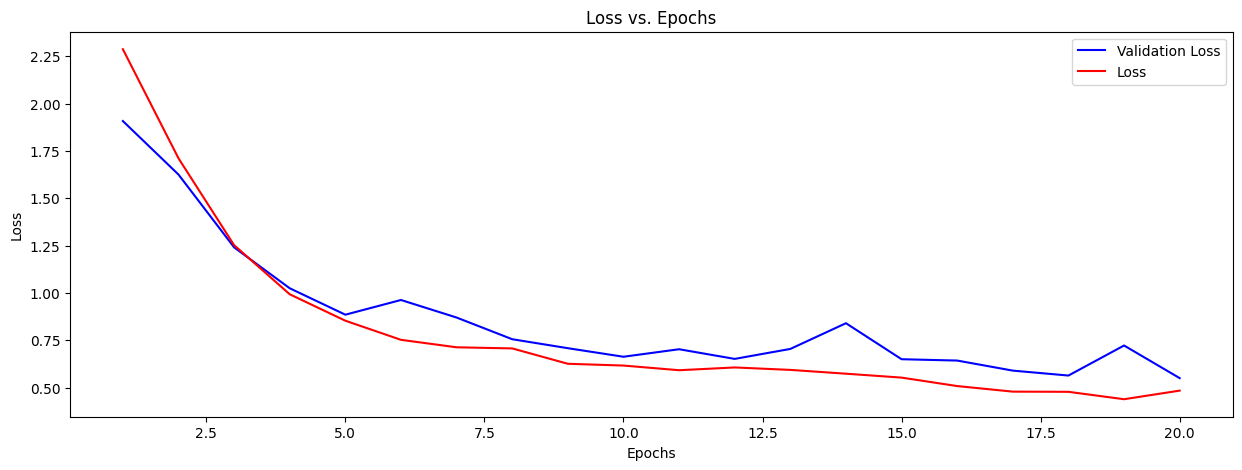

In [15]:
# Plot the history of the model, validation loss and loss

# Extracting the loss on the validation set
val_loss = history.history['val_loss']
loss = history.history['loss']

# Extracting the number of epochs
epochs = range(1, len(val_loss) + 1)

# Plotting the graph for the loss function 
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.plot(epochs, loss, 'r-', label='Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

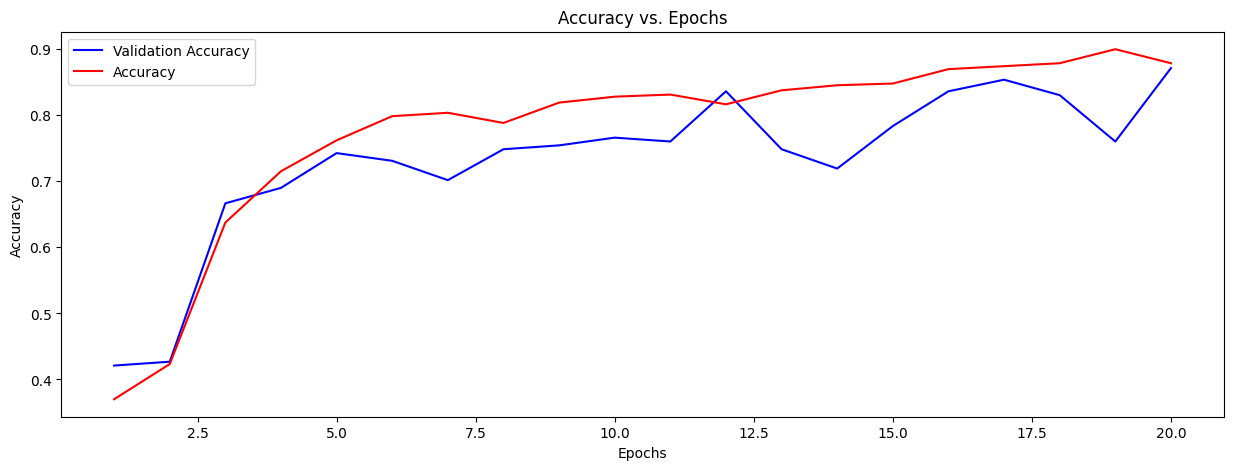

In [16]:
# plot the history of the model, validation accuracy and accuracy
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

#plotting the graph for the accuracy
plt.figure(figsize=(15, 5))
plt.plot(epochs,val_accuracy , 'b-', label='Validation Accuracy')
plt.plot(epochs, accuracy, 'r-', label='Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

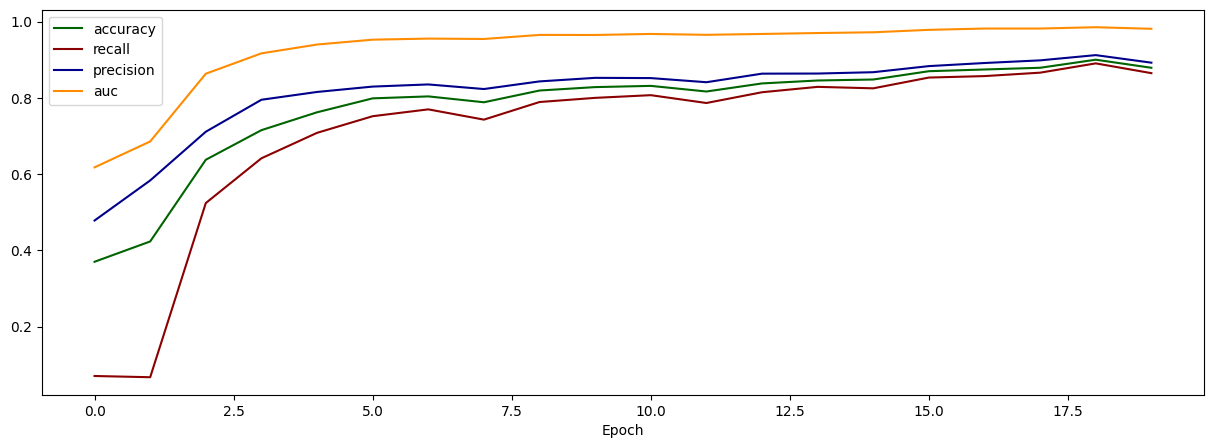

In [17]:
# Plot the history of the model, recall, precision, auc, accuracy and loss
plt.figure(figsize = (15, 5))
plt.plot(history.history['accuracy'], "darkgreen", label= "accuracy")
plt.plot(history.history['recall'], "darkred", label= "recall")
plt.plot(history.history['precision'], "darkblue", label= "precision")
plt.plot(history.history['auc'], "darkorange", label= "auc")
plt.xlabel('Epoch')
plt.legend()

## MODEL EVALUATION

In [19]:
#evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255) 

test_generator = test_datagen.flow_from_directory(
    "PATH TO YOUR TESTING DIRECTORY", 
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale', 
    shuffle=False)

Found 433 images belonging to 4 classes.


In [33]:
# printing the test loss and test accuracy
results = model.evaluate(test_generator)
test_loss = results[0]
test_acc = results[6]

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


433/433 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9197 - auc: 0.9817 - fn: 19.3157 - fp: 16.6705 - loss: 0.4428 - precision: 0.9188 - recall: 0.9095 - tn: 635.8226 - tp: 198.1820
Test Loss: 0.34290194511413574
Test Accuracy: 0.9463869333267212


In [30]:
# Predict the classes with the model
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# setting the true class labels
true_classes = test_generator.classes

# Get the class labels from the generator 
class_labels = list(test_generator.class_indices.keys())

# Calculate the confusion matrix
print(confusion_matrix(true_classes, predicted_classes))

# Calculate the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
[[ 73   0   1   2]
 [  0  55   0  15]
 [  0   1 100   4]
 [  0   0   0 182]]
                       precision    recall  f1-score   support

       Advertisements       1.00      0.96      0.98        76
               E-mail       0.98      0.79      0.87        70
Handwritten Documents       0.99      0.95      0.97       105
               Resumè       0.90      1.00      0.95       182

             accuracy                           0.95       433
            macro avg       0.97      0.92      0.94       433
         weighted avg       0.95      0.95      0.95       433



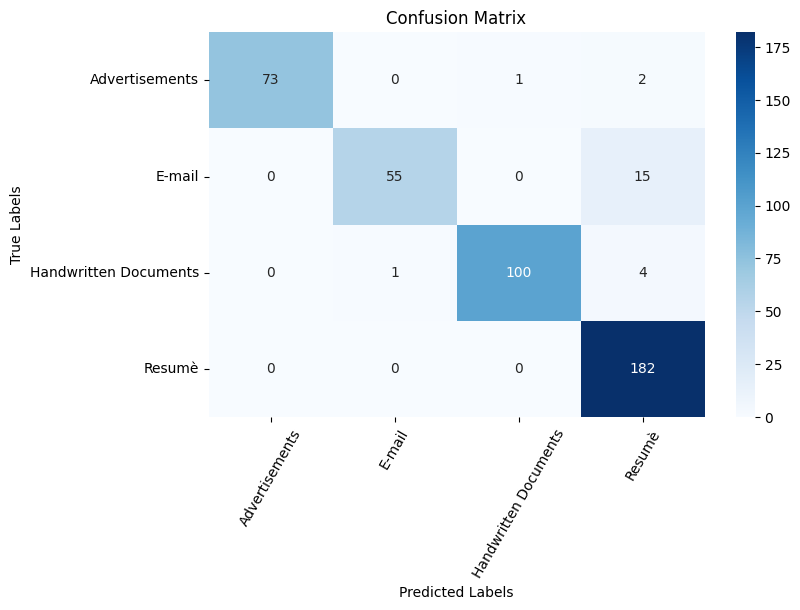

In [24]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=60)
plt.show()

In [26]:
# Reset the test_generator before making predictions to ensure alignment
test_generator.reset()

# Predict the classes with the model
predictions = model.predict(test_generator, verbose=1)

# Get the class indices with the highest probability for each prediction
predicted_classes_indices = np.argmax(predictions, axis=1)

# Get the true class indices from the generator
true_classes = test_generator.classes

# Get the class labels for a better readability in the classification report
class_labels = list(test_generator.class_indices.keys())

# Compare predicted and true class indices
count_true = np.sum(predicted_classes_indices == true_classes)
count_false = len(true_classes) - count_true

# Calculate the error rate
error_rate = count_false / len(true_classes)

# Print the results
print("Number of successes:", count_true)
print("Number of errors:", count_false)
print("Error rate:", error_rate)


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step
Number of successes: 410
Number of errors: 23
Error rate: 0.053117782909930716
